# AnoGAN
- 2020.08.11 : Genrator 학습 수 ... 4

# 개발일지
- 2020.08.14 : 분율 추출 구현
- 2020.08.15 : 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티티늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
data_root = "../../../OhSeHyeon/source/dataset/train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 92
device : cuda:0


# MODEL

In [4]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [7]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 10)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/1]
- D_loss : 1.3850 / G_loss : 0.6736
- D(x) : 0.5018 / D(G(z1)) : 0.5012 / D(G(z2)) : 0.5099
[2/100][0/1]
- D_loss : 1.3912 / G_loss : 0.6647
- D(x) : 0.5023 / D(G(z1)) : 0.5047 / D(G(z2)) : 0.5145
[3/100][0/1]
- D_loss : 1.3976 / G_loss : 0.6569
- D(x) : 0.5032 / D(G(z1)) : 0.5087 / D(G(z2)) : 0.5185
[4/100][0/1]
- D_loss : 1.4031 / G_loss : 0.6511
- D(x) : 0.5042 / D(G(z1)) : 0.5124 / D(G(z2)) : 0.5215
[5/100][0/1]
- D_loss : 1.4102 / G_loss : 0.6434
- D(x) : 0.5050 / D(G(z1)) : 0.5166 / D(G(z2)) : 0.5255
[6/100][0/1]
- D_loss : 1.4142 / G_loss : 0.6398
- D(x) : 0.5055 / D(G(z1)) : 0.5190 / D(G(z2)) : 0.5274
[7/100][0/1]
- D_loss : 1.4210 / G_loss : 0.6344
- D(x) : 0.5057 / D(G(z1)) : 0.5224 / D(G(z2)) : 0.5303
[8/100][0/1]
- D_loss : 1.4242 / G_loss : 0.6312
- D(x) : 0.5062 / D(G(z1)) : 0.5245 / D(G(z2)) : 0.5320
[9/100][0/1]
- D_loss : 1.4286 / G_loss : 0.6267
- D(x) : 0.5068 / D(G(z1)) : 0.5271 / D(G(z2)) : 0.5344
[10/100][0/1]
- D_loss : 1.4345 / G_loss : 0.6222
- D(x

[79/100][0/1]
- D_loss : 1.5095 / G_loss : 0.5447
- D(x) : 0.5249 / D(G(z1)) : 0.5788 / D(G(z2)) : 0.5800
[80/100][0/1]
- D_loss : 1.5123 / G_loss : 0.5439
- D(x) : 0.5246 / D(G(z1)) : 0.5797 / D(G(z2)) : 0.5805
[81/100][0/1]
- D_loss : 1.5137 / G_loss : 0.5434
- D(x) : 0.5242 / D(G(z1)) : 0.5800 / D(G(z2)) : 0.5808
[82/100][0/1]
- D_loss : 1.5123 / G_loss : 0.5420
- D(x) : 0.5252 / D(G(z1)) : 0.5801 / D(G(z2)) : 0.5816
[83/100][0/1]
- D_loss : 1.5160 / G_loss : 0.5403
- D(x) : 0.5248 / D(G(z1)) : 0.5813 / D(G(z2)) : 0.5826
[84/100][0/1]
- D_loss : 1.5181 / G_loss : 0.5375
- D(x) : 0.5254 / D(G(z1)) : 0.5827 / D(G(z2)) : 0.5842
[85/100][0/1]
- D_loss : 1.5195 / G_loss : 0.5365
- D(x) : 0.5256 / D(G(z1)) : 0.5835 / D(G(z2)) : 0.5848
[86/100][0/1]
- D_loss : 1.5224 / G_loss : 0.5356
- D(x) : 0.5253 / D(G(z1)) : 0.5844 / D(G(z2)) : 0.5853
[87/100][0/1]
- D_loss : 1.5248 / G_loss : 0.5351
- D(x) : 0.5249 / D(G(z1)) : 0.5851 / D(G(z2)) : 0.5856
[88/100][0/1]
- D_loss : 1.5224 / G_loss : 0.5

# Graph

In [8]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

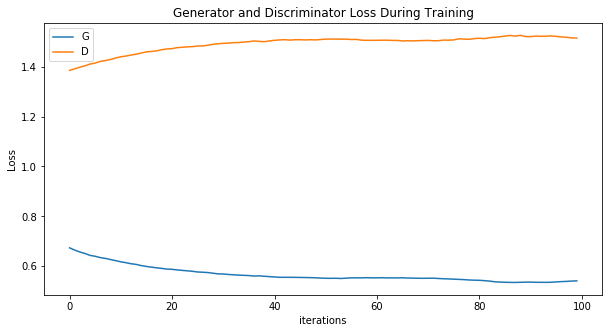

In [9]:
plot_train_loss()

# Animation

In [10]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

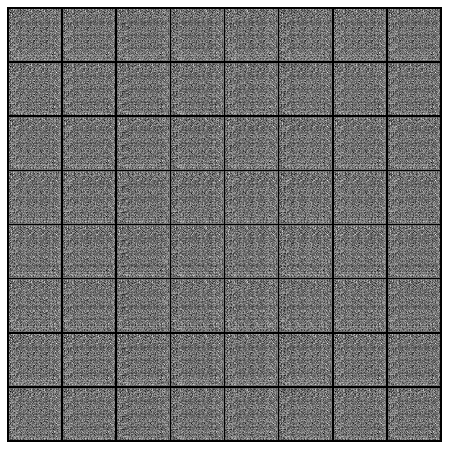

In [11]:
animate_gen_imgs()

# Anomaly Loss

In [12]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    _, Test_Data_feature = D(Test_Data)
    _, G_Data_feature = D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_CFRP"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [13]:
latent_space = []
auc=[]

def train_latent_space():
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step == 400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss > 500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [14]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1029.6423  Sum_of_z : 3.2291
[200]	 Ano_loss : 1029.3416  Sum_of_z : -4.7635
[400]	 Ano_loss : 1029.2954  Sum_of_z : -10.7765
picture  2
[0]	 Ano_loss : 778.6153  Sum_of_z : -10.8232
[200]	 Ano_loss : 777.5582  Sum_of_z : 1.3441
[400]	 Ano_loss : 777.5377  Sum_of_z : 3.8813
picture  3
[0]	 Ano_loss : 398.6686  Sum_of_z : 3.8097
[200]	 Ano_loss : 397.8454  Sum_of_z : -0.8270
[400]	 Ano_loss : 397.6950  Sum_of_z : -4.8157
picture  4
[0]	 Ano_loss : 968.0966  Sum_of_z : -5.0205
[200]	 Ano_loss : 967.2729  Sum_of_z : -9.1141
[400]	 Ano_loss : 967.1488  Sum_of_z : -16.9340
picture  5
[0]	 Ano_loss : 968.6439  Sum_of_z : -17.1591
[200]	 Ano_loss : 967.6999  Sum_of_z : -0.6808
[400]	 Ano_loss : 967.6755  Sum_of_z : -2.2484
picture  6
[0]	 Ano_loss : 1100.3264  Sum_of_z : -2.5459
[200]	 Ano_loss : 1099.2913  Sum_of_z : -19.7657
[400]	 Ano_loss : 1099.2755  Sum_of_z : -18.1706
picture  7
[0]	 Ano_loss : 1446.5106  Sum_of_z : -18.4610
[200]	 Ano_loss : 1445.5969  Sum_o

[400]	 Ano_loss : 1154.1182  Sum_of_z : 12.6964
picture  55
[0]	 Ano_loss : 906.9565  Sum_of_z : 12.8954
[200]	 Ano_loss : 906.1945  Sum_of_z : 19.3864
[400]	 Ano_loss : 906.1348  Sum_of_z : 18.0347
picture  56
[0]	 Ano_loss : 1347.1227  Sum_of_z : 18.0673
[200]	 Ano_loss : 1346.7012  Sum_of_z : 10.6814
[400]	 Ano_loss : 1346.6307  Sum_of_z : -2.0257
picture  57
[0]	 Ano_loss : 1940.5848  Sum_of_z : -1.8804
[200]	 Ano_loss : 1939.6975  Sum_of_z : 16.9446
[400]	 Ano_loss : 1939.6366  Sum_of_z : 12.0956
picture  58
[0]	 Ano_loss : 1623.6487  Sum_of_z : 11.9366
[200]	 Ano_loss : 1623.3280  Sum_of_z : 6.4324
[400]	 Ano_loss : 1623.2456  Sum_of_z : 3.9005
picture  59
[0]	 Ano_loss : 1712.3630  Sum_of_z : 3.9440
[200]	 Ano_loss : 1712.2875  Sum_of_z : 1.4164
[400]	 Ano_loss : 1712.2664  Sum_of_z : 0.0118
picture  60
[0]	 Ano_loss : 406.9733  Sum_of_z : -0.2122
[200]	 Ano_loss : 406.1975  Sum_of_z : -2.9673
[400]	 Ano_loss : 406.1114  Sum_of_z : -16.6860


---

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# Similar Z , Ano_Score and Segementation


In [16]:
diff_cnts = []
diff_points = []
anomaly_imgs = []


def compare_imgs(real_img, generated_img, i, reverse=False, threshold=50):
    global anomaly_img
    
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

/home/piai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


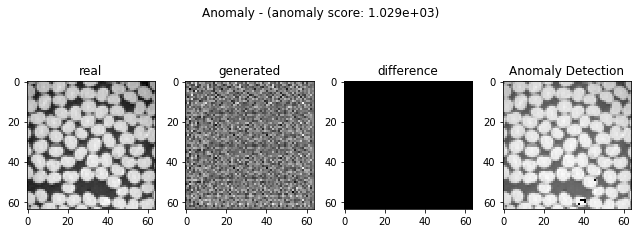

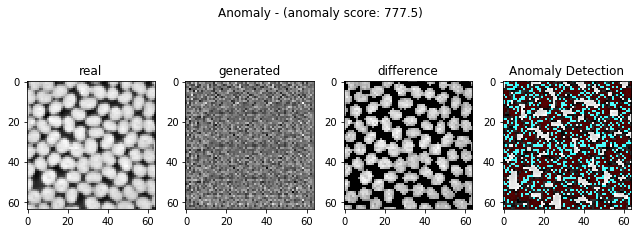

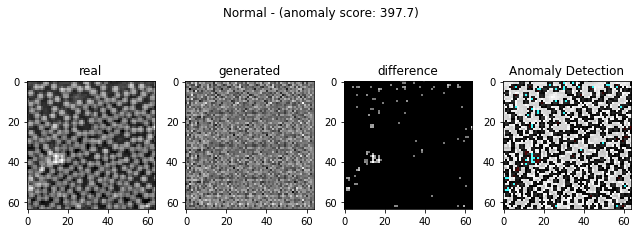

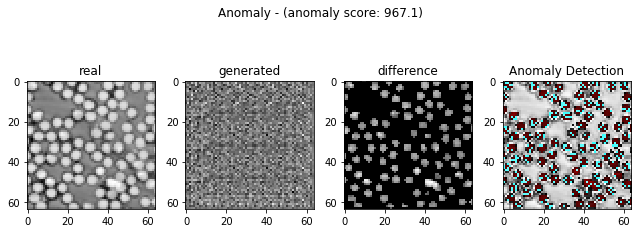

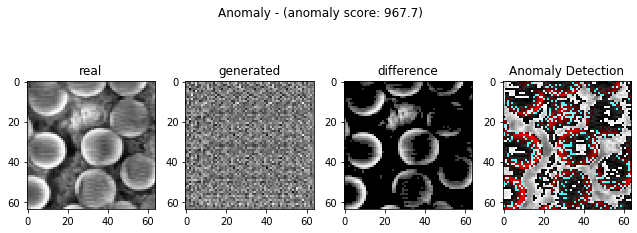

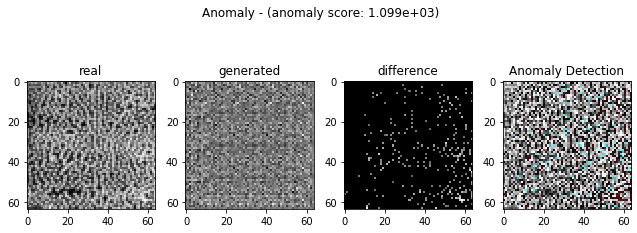

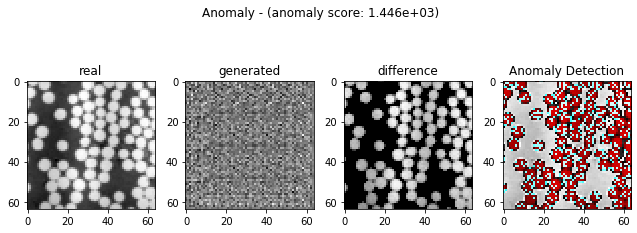

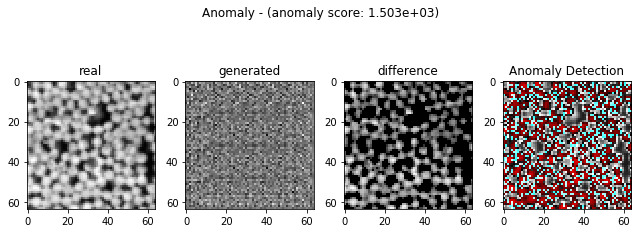

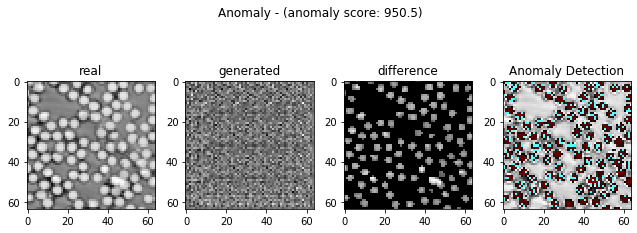

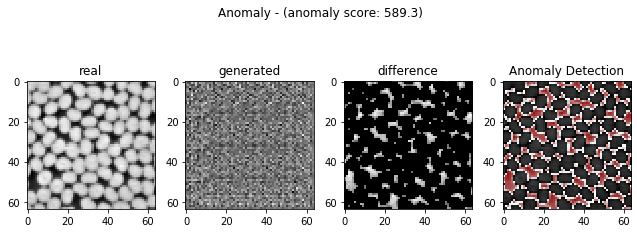

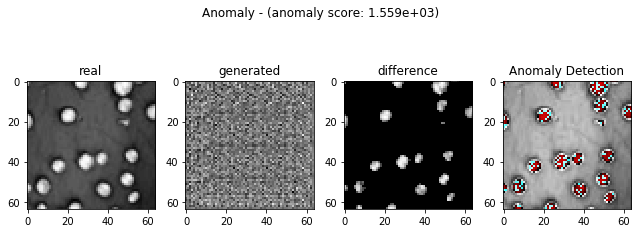

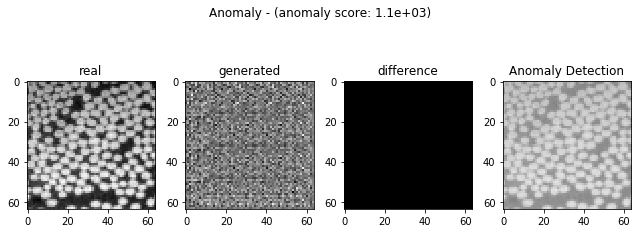

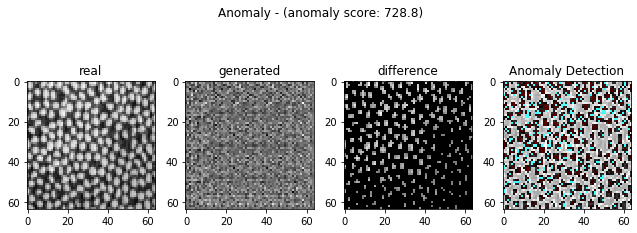

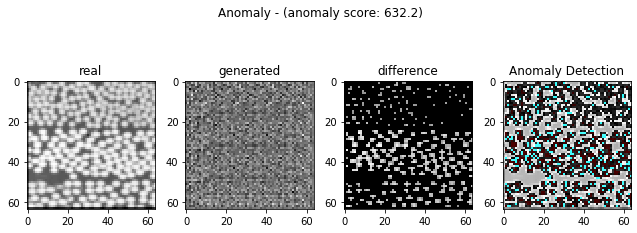

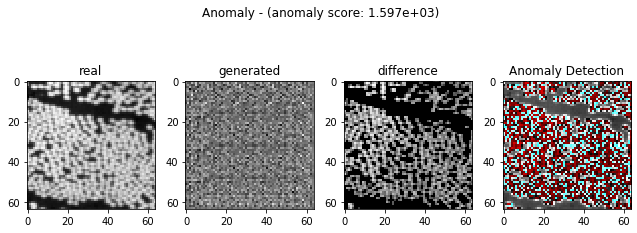

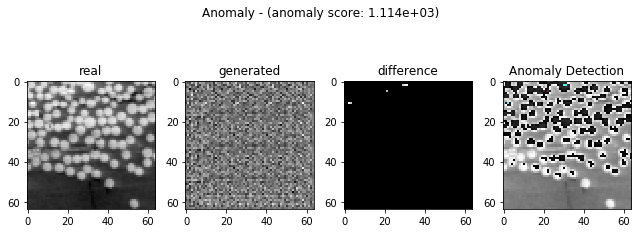

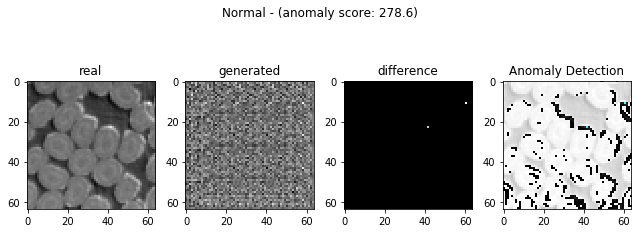

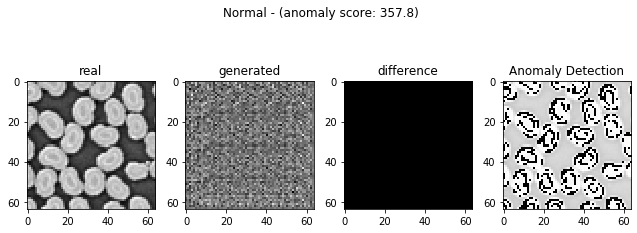

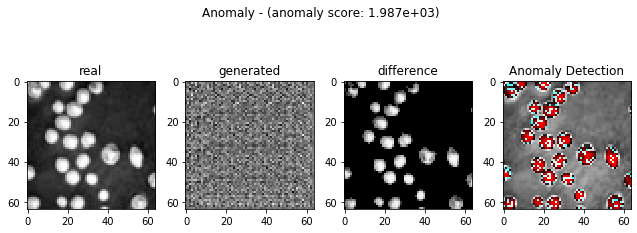

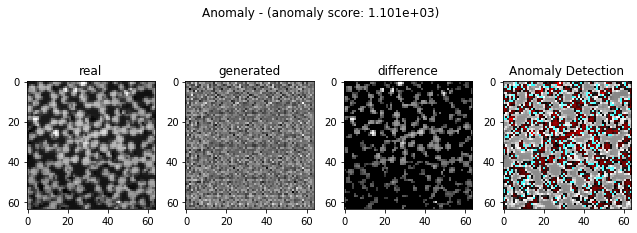

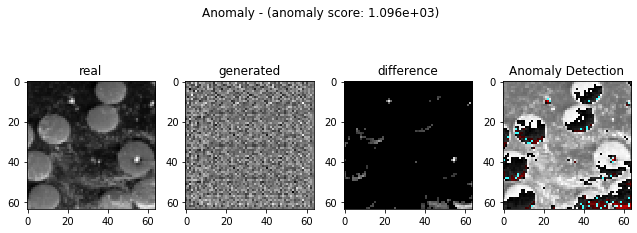

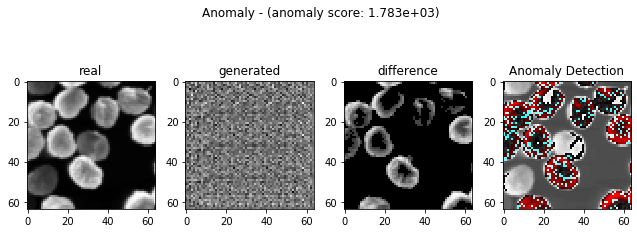

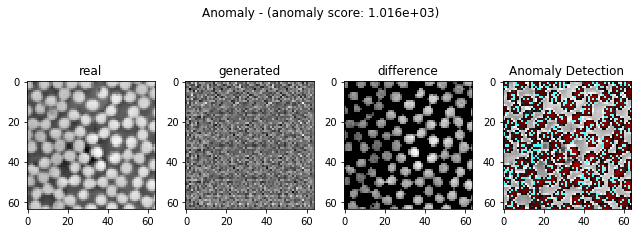

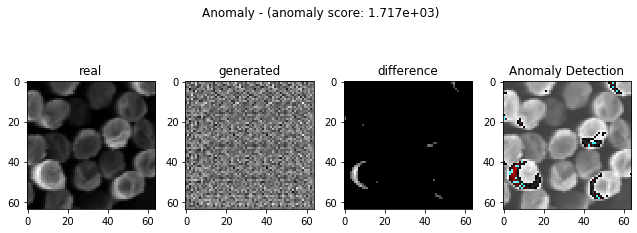

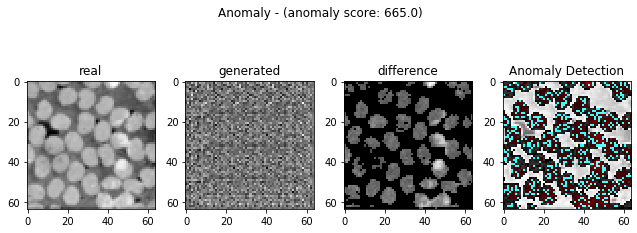

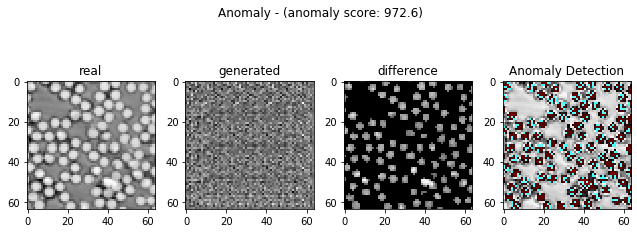

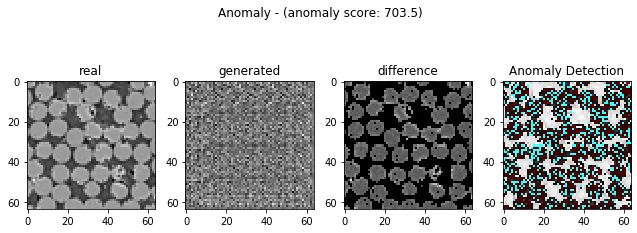

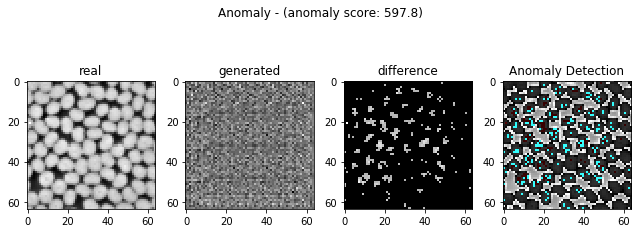

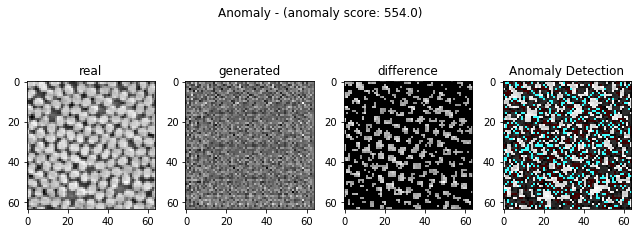

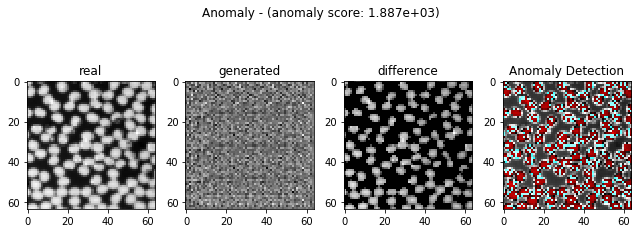

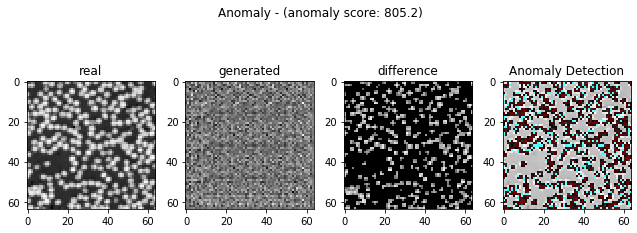

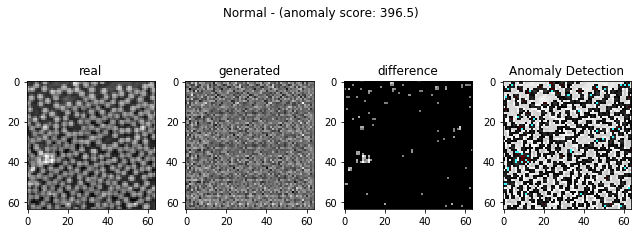

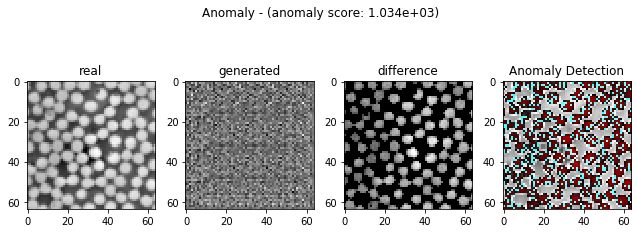

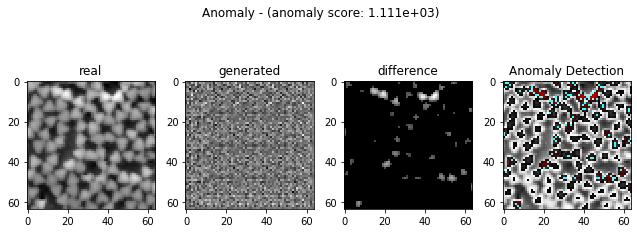

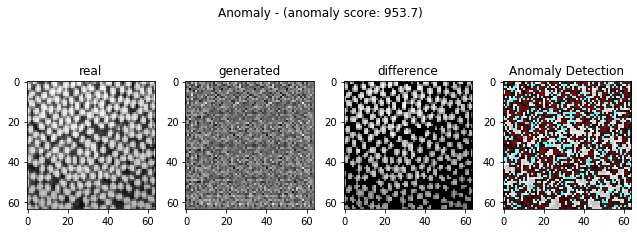

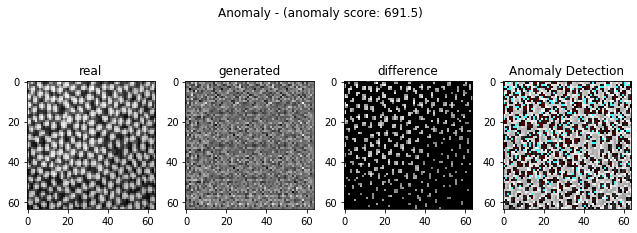

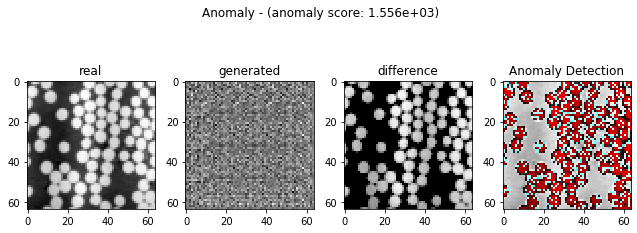

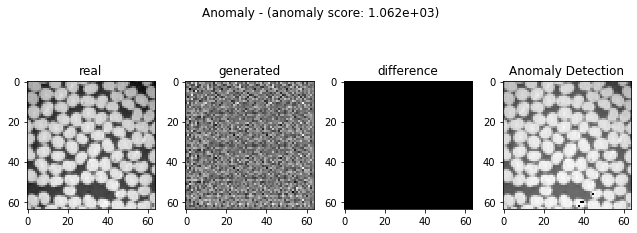

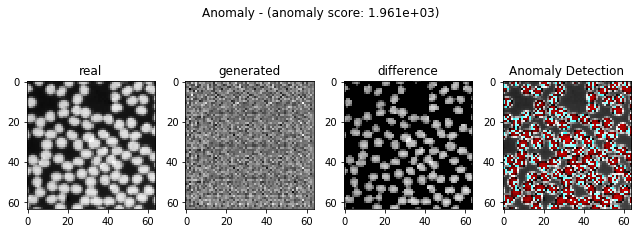

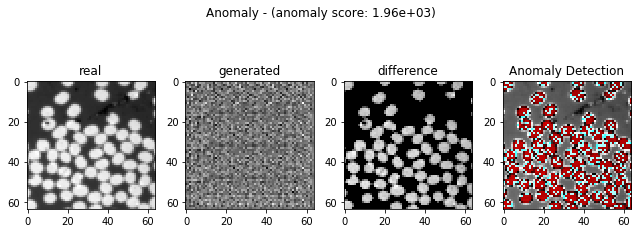

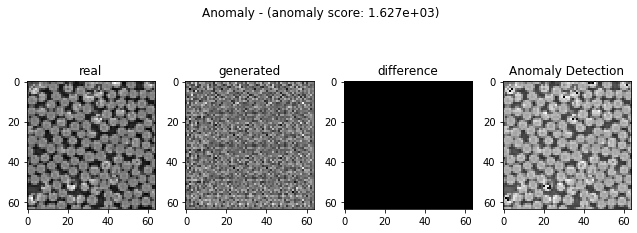

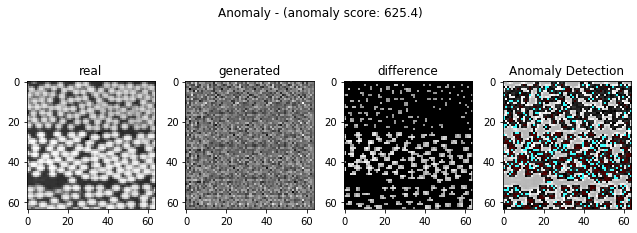

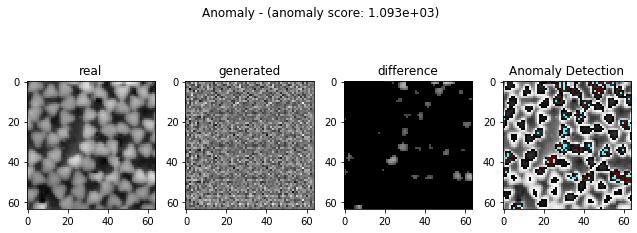

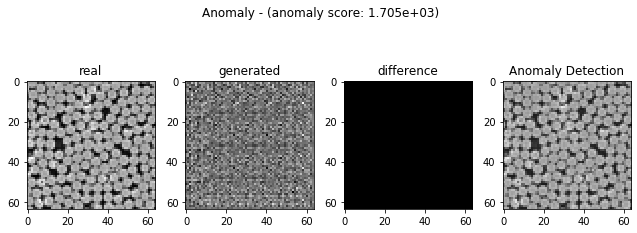

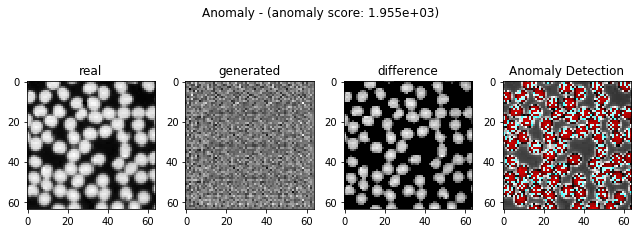

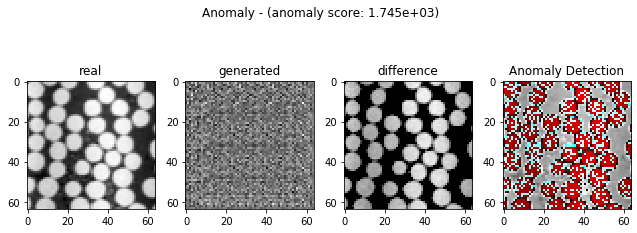

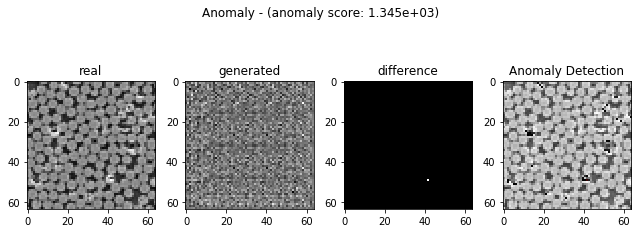

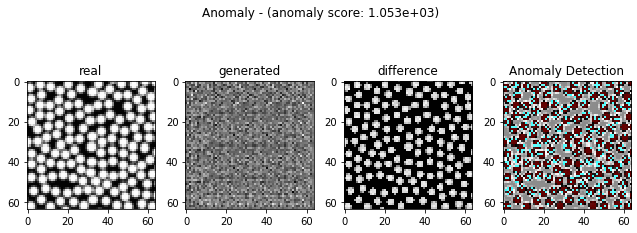

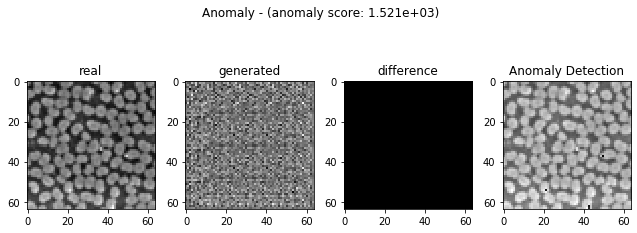

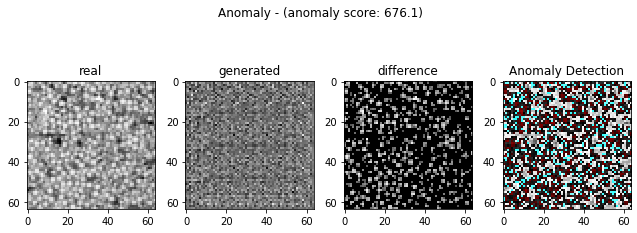

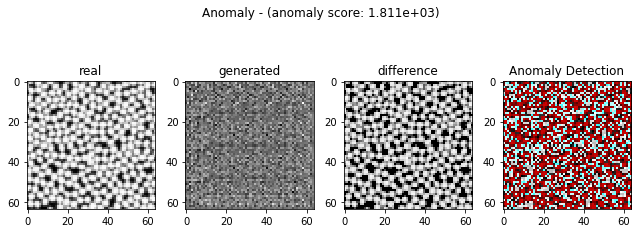

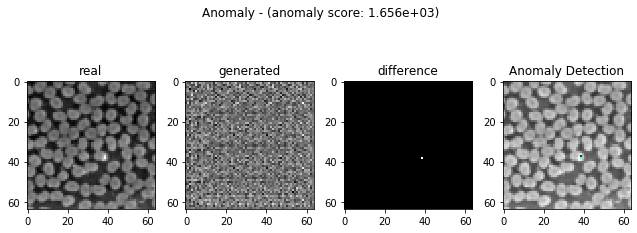

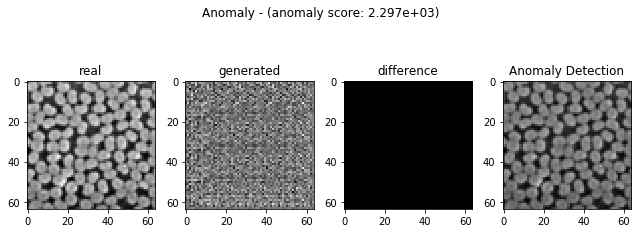

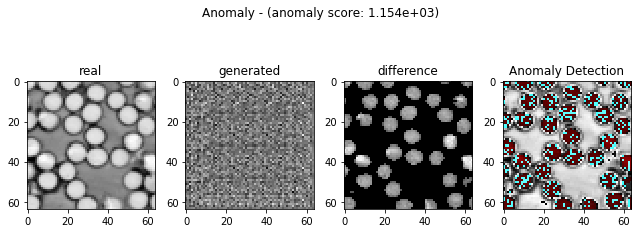

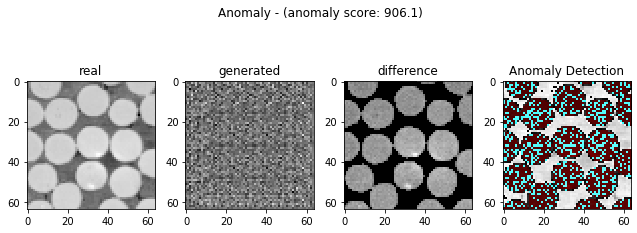

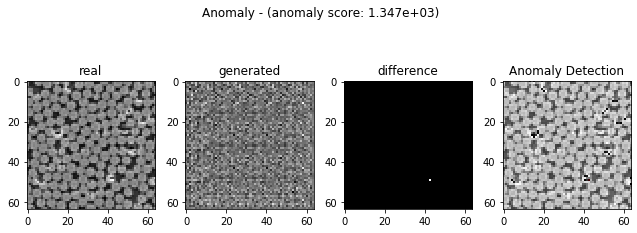

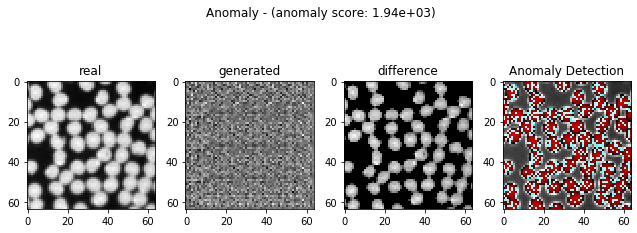

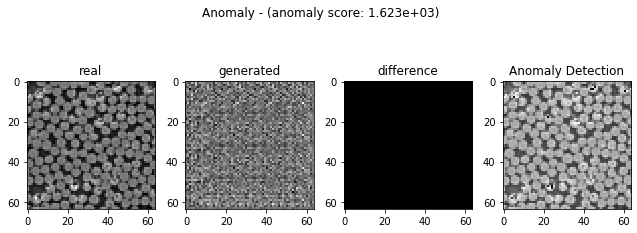

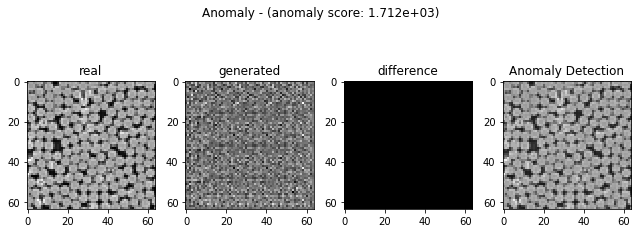

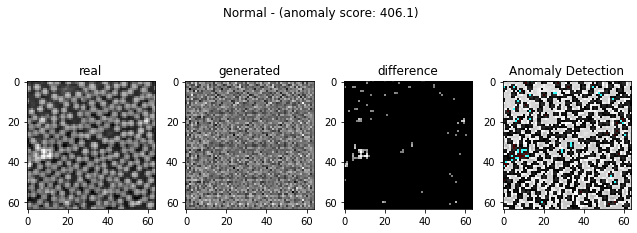

In [17]:
for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.00000000e+00 6.02539062e-01 2.63671875e-02 2.58300781e-01
 3.41796875e-01 6.46972656e-02 5.30761719e-01 5.76171875e-01
 2.54638672e-01 1.84082031e-01 9.08203125e-02 0.00000000e+00
 2.02636719e-01 1.94335938e-01 5.51757812e-01 1.46484375e-03
 4.88281250e-04 0.00000000e+00 1.89208984e-01 3.28857422e-01
 4.85839844e-02 2.87841797e-01 4.37744141e-01 1.75781250e-02
 3.97949219e-01 2.62695312e-01 5.41259766e-01 8.34960938e-02
 2.80761719e-01 4.14306641e-01 2.70263672e-01 2.63671875e-02
 4.45556641e-01 6.93359375e-02 5.23925781e-01 1.81396484e-01
 5.23925781e-01 0.00000000e+00 4.10156250e-01 4.17236328e-01
 0.00000000e+00 2.24853516e-01 6.07910156e-02 0.00000000e+00
 4.56787109e-01 5.67138672e-01 2.44140625e-04 3.78662109e-01
 0.00000000e+00 3.09326172e-01 7.77099609e-01 2.44140625e-04
 0.00000000e+00 3.12011719e-01 6.16699219e-01 2.44140625e-04
 4.68017578e-01 0.00000000e+00 0.00000000e+00 2.31933594e-02]


---

# 분산 추출

In [19]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)
        print(corr_coeffi)

In [20]:
cal_corr_coeffis()

print(corr_coeffis)

-inf
0.017082227826168216
-0.23636075980991178
-0.04430877920778029
0.030499234807075608
0.09466460642881135
-0.0013893760495793774
-0.012087521465550291
-0.002595896762705256
-0.07703728692630013
-0.2925996010527659
-inf
-0.04669691567240515
0.17161179724124703
0.08105617793183391
-0.9986177982684513
-1.0
-inf
0.3067250969061112
0.10689728008533318
0.4683085163139342
0.07118899878043972
-0.02398208014400726
-0.531684963817514
0.01811312274635251
-0.039127296498542505
-0.04029198814792484
-0.09995937711213801
0.07071491577520196
-0.05415929800769713
0.031068556354637088
-0.13858256055655915
-0.03587783308452384
0.1131591300029918
-0.03418618647963231
-0.013609891847653637
0.011170387575093664
-inf
-0.027229865490466017
0.06150160055781022
-inf
0.1377464827778374
-0.1391045374762977
-inf
-0.01506151224333635
0.0089613346705016


ValueError: x and y must have length at least 2.

---

# 모델 저장 및 읽기

In [21]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "G" : G.state_dict(),
        #"latent_space" : latent_space.state_dict(), # nn.model만 가지는 기능
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [22]:
save_pretrained()

In [23]:
pretrained_D = Discriminator().to(device)
pretrained_G = Generator().to(device)
#pretrained_latent_space = [] # 다시 학습해야 함

def load_pretrained():
    global pretrained_D
    global pretrained_G
    #global pretrained_latent_space
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_G.load_state_dict(pretrained["G"])
    #pretrained_latent_space.load_state_dict(pretrained["latent_space"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_G)
    #print("pretrained_latent_space :", pretrained_latent_space)

In [24]:
load_pretrained()

In [25]:
def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature = pretrained_D(Test_Data)
    _, G_Data_feature = pretrained_D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

In [26]:
# train latent_space

latent_space = []
auc = []

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = pretrained_G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [27]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1266.3403  Sum_of_z : -3.3242
[200]	 Ano_loss : 1264.7040  Sum_of_z : 0.9610
[400]	 Ano_loss : 1264.6361  Sum_of_z : 1.0947
picture  2
[0]	 Ano_loss : 1201.3168  Sum_of_z : 1.3532
[200]	 Ano_loss : 1199.7808  Sum_of_z : 11.9149
[400]	 Ano_loss : 1199.6984  Sum_of_z : 12.8498
picture  3
[0]	 Ano_loss : 1015.5364  Sum_of_z : 12.9203
[200]	 Ano_loss : 1013.7377  Sum_of_z : 6.7273
[400]	 Ano_loss : 1013.6226  Sum_of_z : -1.5176
picture  4
[0]	 Ano_loss : 524.4009  Sum_of_z : -1.5813
[200]	 Ano_loss : 523.0158  Sum_of_z : -6.6464
[400]	 Ano_loss : 522.9283  Sum_of_z : -4.0442
picture  5
[0]	 Ano_loss : 1090.5264  Sum_of_z : -4.1989
[200]	 Ano_loss : 1090.0314  Sum_of_z : -11.3059
[400]	 Ano_loss : 1090.0150  Sum_of_z : -12.8962
picture  6
[0]	 Ano_loss : 345.9109  Sum_of_z : -12.8769
[200]	 Ano_loss : 344.4709  Sum_of_z : 4.4213
[400]	 Ano_loss : 344.2828  Sum_of_z : 12.5208
picture  7
[0]	 Ano_loss : 671.7592  Sum_of_z : 12.4988
[200]	 Ano_loss : 670.0259  Sum_of

In [28]:
def test():
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)

        #for i in range(len(latent_space)):
        update_z = latent_space[i]
        R_img = test_img
        G_img = pretrained_G(update_z).to(device)

        if i in [9]:
            compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
        else:
            compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

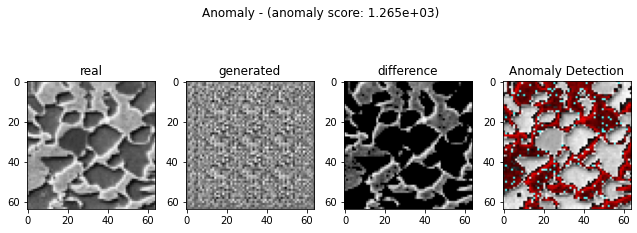

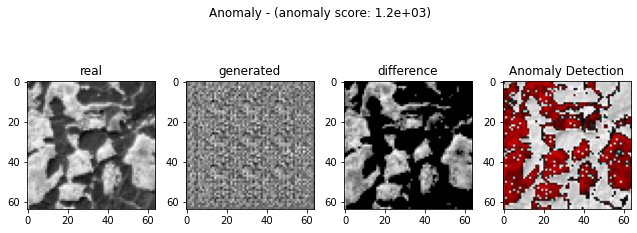

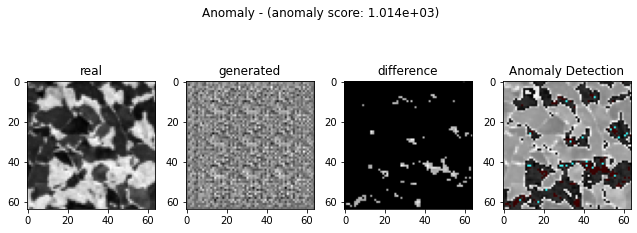

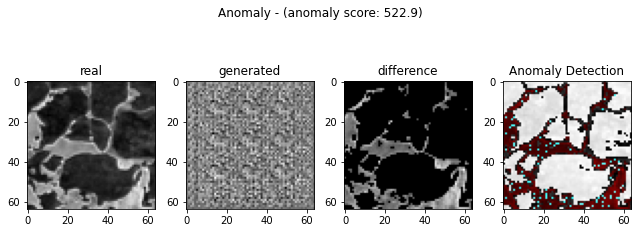

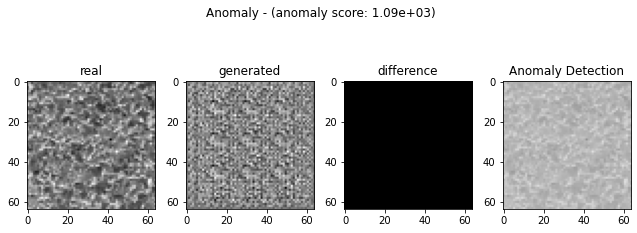

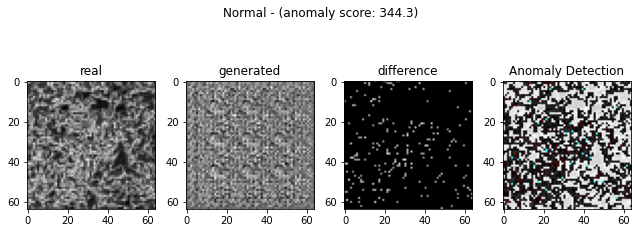

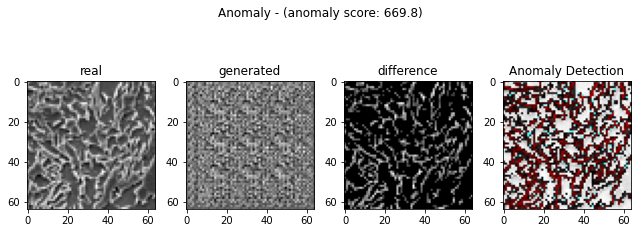

In [29]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [30]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.42578125 0.46264648 0.04516602 0.2355957  0.         0.04980469
 0.29760742]


In [31]:
cal_corr_coeffis()

print(corr_coeffis)

[0.03930323451955458, 0.09824271107967668, -0.28914111459826475, 0.19809595979534306, -inf, 0.04507935167666852, -0.08497257982755216]


---

# anomaly detection 이미지 추출

In [32]:
anomaly_imgs

[array([[[242, 242, 242],
         [246, 246, 246],
         [121,   0,   0],
         ...,
         [210, 210, 210],
         [176, 176, 176],
         [222, 222, 222]],
 
        [[248, 248, 248],
         [242, 242, 242],
         [ 87,   1,   1],
         ...,
         [238, 238, 238],
         [238, 238, 238],
         [190, 190, 190]],
 
        [[236, 236, 236],
         [230, 230, 230],
         [ 77,   3,   3],
         ...,
         [230, 230, 230],
         [232, 232, 232],
         [238, 238, 238]],
 
        ...,
 
        [[230, 230, 230],
         [248, 248, 248],
         [212, 212, 212],
         ...,
         [142, 142, 142],
         [ 85,  85,  85],
         [130, 130, 130]],
 
        [[228, 228, 228],
         [244, 244, 244],
         [230, 230, 230],
         ...,
         [105, 105, 105],
         [150, 150, 150],
         [252, 252, 252]],
 
        [[218, 218, 218],
         [228, 228, 228],
         [246, 246, 246],
         ...,
         [182, 182, 182],
  

# 이미지 저장 함수

In [33]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [34]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [35]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.88621094 2.04952393 0.20008545 1.04368896 0.         0.22063477
 1.31840088]
